# Reweighting MC simulation to data using a NN
Reweighting MC simulations to data is a common task used to improve the modelling. The most common practice is to reweight a single variable of particular importance in an analysis. This example demonstrates how a NN can be used to perform the reweighting task by considering multiple variables together, which improves the modelling across multiple variables and can account for correlations between variables.

**Many thanks to Michele Faucci Giannelli, Marilena Bandieramonte and Martina Javurkova**

In [1]:
pip install -U tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
tfd = tfp.distributions

2023-12-20 11:50:37.479617: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 11:50:37.574083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 11:50:37.574165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 11:50:37.576452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 11:50:37.590415: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 11:50:37.591420: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Model the variables with models for data and MC that are similar but have differences that we want to reweight. 
This section generates the data and MC samples.

In [3]:
data_model_var1 = tfd.mixture.Mixture(tfd.Categorical(probs=[0.4, 0.6]),
            components=[
              tfd.Normal(loc=0., scale=0.1),
              tfd.Normal(loc=0., scale=0.8),
            ])
data_model_var2 = tfd.Exponential(0.2)

mc_model_var1 = tfd.mixture.Mixture(tfd.Categorical(probs=[0.3, 0.7]),
            components=[
              tfd.Normal(loc=0.1, scale=0.1),
              tfd.Normal(loc=0., scale=1),
            ])
mc_model_var2 = tfd.Exponential(0.4)

## Generate the random data from the model
The generated data has 3 columns. The first two are two observed variables, the third is the label: 0 for data, 1 for MC

In [4]:
NSAMPLE = 100000
data_var1 = data_model_var1.sample(NSAMPLE).numpy()
data_var2 = data_model_var2.sample(NSAMPLE).numpy()
mc_var1 = mc_model_var1.sample(NSAMPLE).numpy()
mc_var2 = mc_model_var2.sample(NSAMPLE).numpy()

Add a rotation to create correlations and make these correlations different in data and MC.

In [5]:
data_var1, data_var2 = 0.7 * data_var1 + 0.3 * data_var2, 0.3 * data_var1 + 0.7 * data_var2

mc_var1, mc_var2 = 0.9 * mc_var1 + 0.1 * mc_var2, 0.1 * mc_var1 + 0.9 * mc_var2

Merge the variables in a single vector, put a flag as the last element (0/1 for data/MC respectively).

In [6]:
data = np.vstack([data_var1, data_var2, np.zeros(NSAMPLE)]).T
mc = np.vstack([mc_var1, mc_var2, np.ones(NSAMPLE)]).T

#### Apply selections to the data
Here one can implement selections to focus on specific parts of the distribution. It is especially challenging to model the tails of distributions, so these can be reduced so that the training focuses on the bulk of the distribution.

In [7]:
#data_cut1 = data[data[:,0]>-5]
#data_cut2 = data_cut1[data_cut1[:,0]<10]
#data_cut3 = data_cut2[data_cut2[:,1]<20]
#mc_cut1 = mc[mc[:,0]>-5]
#mc_cut2 = mc_cut1[mc_cut1[:,0]<10]
#mc_cut3 = mc_cut2[mc_cut2[:,1]<20]
#data_sel = data_cut3
#mc_sel = mc_cut3

#### Create training and testing samples
Create a sample by mixing and shuffling data and MC. 

In [8]:
#sample = np.vstack([data_sel, mc_sel])
sample = np.vstack([data, mc])
np.random.shuffle(sample)
NSAMPLE=len(sample)

Divide the dataset into training and testing samples by splitting them in half.

In [9]:
training_sample = sample[int(NSAMPLE / 2):]
testing_sample = sample[:int(NSAMPLE / 2)]

X_train = training_sample[:, :-1]
Y_train = training_sample[:, -1]

## Plot the variables before the correction

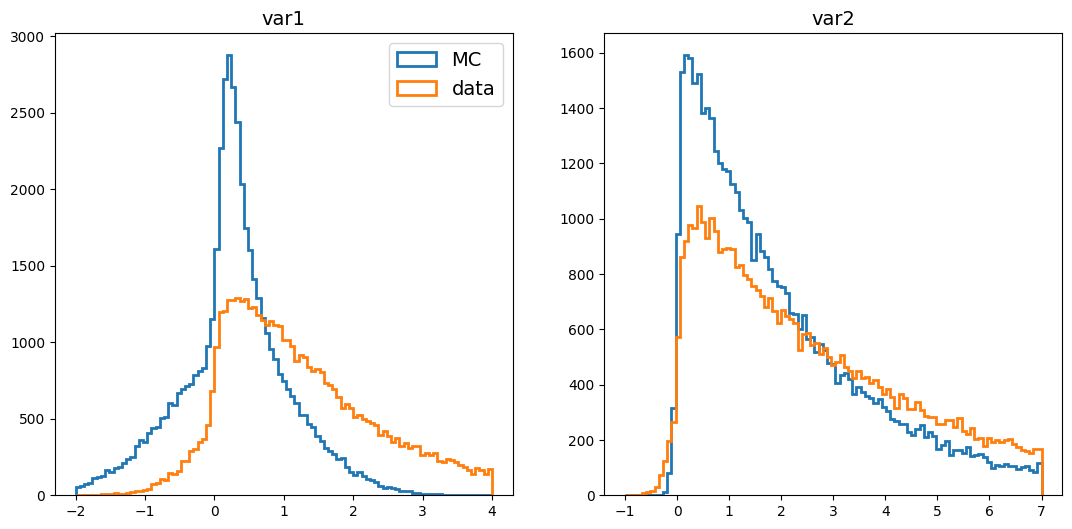

In [10]:
testing_sample_mc = testing_sample[testing_sample[:, -1] == 1]
testing_sample_data = testing_sample[testing_sample[:, -1] == 0]

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
bins = np.linspace(-2, 4, 100)
axs[0].hist(testing_sample_mc[:, 0], bins=bins, histtype='step', label='MC', lw=2)
axs[0].hist(testing_sample_data[:, 0], bins=bins, histtype='step', label='data', lw=2)
axs[0].legend(loc=0, fontsize=14)
axs[0].set_title('var1', fontsize=14)

bins = np.linspace(-1, 7, 100)
axs[1].hist(testing_sample_mc[:, 1], bins=bins, histtype='step', lw=2)
axs[1].hist(testing_sample_data[:, 1], bins=bins, histtype='step', lw=2)
axs[1].set_title('var2', fontsize=14)


plt.show()

## Optimize the classifier, optimizing the cross entropy
Optimize a classifier to distinguish between data and MC

In [11]:
classifier = tf.keras.Sequential([
    tf.keras.Input(X_train.shape[1]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(loss='binary_crossentropy', metrics='accuracy')
classifier.fit(X_train, Y_train, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 10s 3ms/step - loss: 0.4167 - accuracy: 0.7985
Epoch 2/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.4003 - accuracy: 0.8083
Epoch 3/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3969 - accuracy: 0.8075
Epoch 4/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3947 - accuracy: 0.8080
Epoch 5/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3930 - accuracy: 0.8086
Epoch 6/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3916 - accuracy: 0.8099
Epoch 7/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3903 - accuracy: 0.8104
Epoch 8/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3891 - accuracy: 0.8116
Epoch 9/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.3884 - accuracy: 0.8111
Epoch 10/10
3125/3125 [==============================] - 8s 3ms/step - loss: 0.38

## Compute the weight on the test sample (the value is close to 1)

The weight is just the ratio between

$$w = \frac{P[data|q]}{P[MC|q]}$$

Where $q$ is our variable(s). Usually this is estimated with a multi-dimensional histogram, or just ignoring correlation using a set of 1D histograms.

A perfect classifier will return $y=P[data|x]$. Of course $P[MC|x] = 1 - P[data|x]$, where $x$ are the feature of one event. So:

$$w = \frac{y}{1 - y}$$

Note that if we have data very similar to MC we will get a very poor classifier, which will output 0.5, and so the weight will be 1.

An additional thing to do (not done here), is to calibrate the classifier.

In [12]:
print(len(testing_sample_mc))
weights = classifier.predict(testing_sample_mc[:, :-1])
weights = weights / (1 - weights)    

49863
1559/1559 [==============================] - 3s 2ms/step


/tmp/ipykernel_3833/1253959975.py:3: RuntimeWarning: divide by zero encountered in divide
  weights = weights / (1 - weights)


## Distribution of the weights from the NN

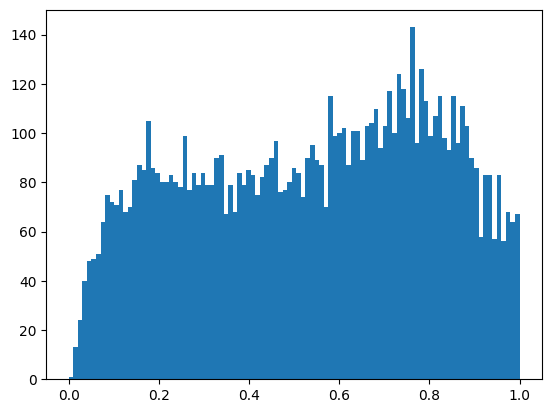

In [13]:
fig, ax = plt.subplots()
ax.hist(weights, bins=np.linspace(0, 1, 100))
plt.show()

## Apply the weights and plot the distributions

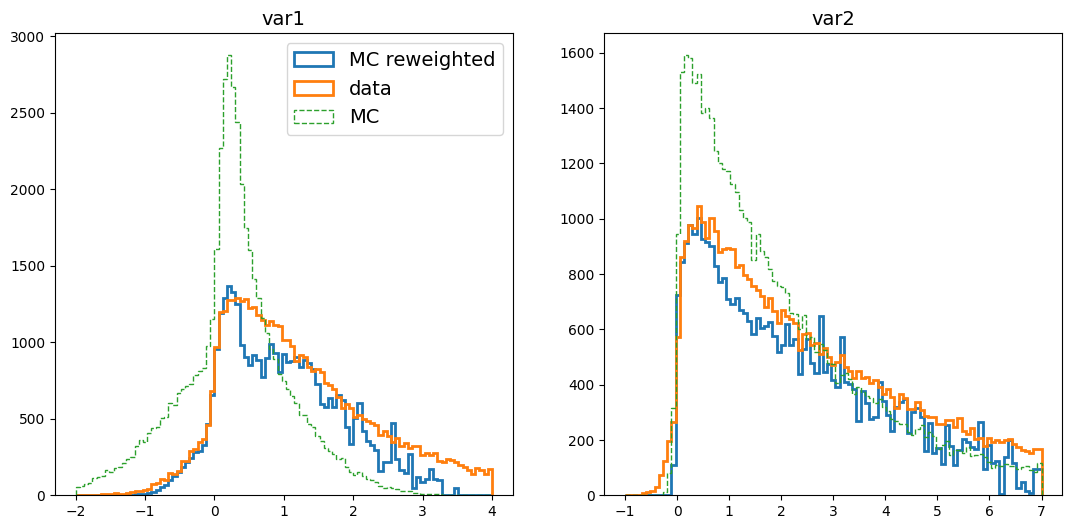

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
bins = np.linspace(-2, 4, 100)
axs[0].hist(testing_sample_mc[:, 0], weights=1/weights, bins=bins, histtype='step', label='MC reweighted', lw=2)
axs[0].hist(testing_sample_data[:, 0], bins=bins, histtype='step', label='data', lw=2)
axs[0].hist(testing_sample_mc[:, 0], bins=bins, histtype='step', label='MC', ls='--')
axs[0].legend(loc=0, fontsize=14)
axs[0].set_title('var1', fontsize=14)

bins = np.linspace(-1, 7, 100)
axs[1].hist(testing_sample_mc[:, 1], weights=1/weights, bins=bins, histtype='step', lw=2)
axs[1].hist(testing_sample_data[:, 1], bins=bins, histtype='step', lw=2)
axs[1].hist(testing_sample_mc[:, 1], bins=bins, histtype='step', label='MC', ls='--')
axs[1].set_title('var2', fontsize=14)

plt.show()

## Look at the correlation
Check to see if the reweighed MC reproduces the correlation in data!

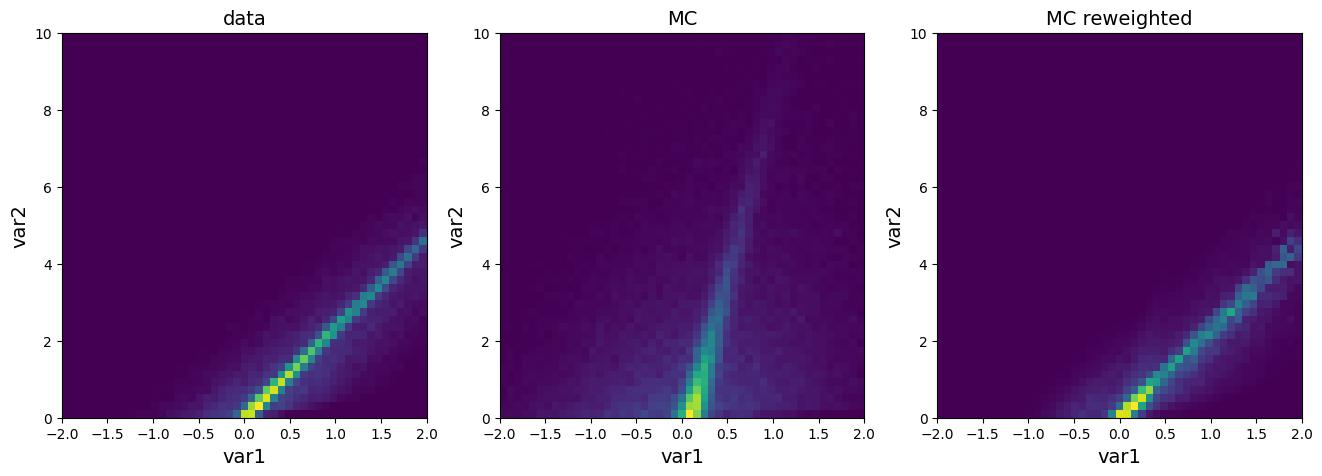

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
bins = [np.linspace(-2, 2, 50), np.linspace(0., 10, 50)]
axs[0].hist2d(testing_sample_data[:, 0], testing_sample_data[:, 1], bins=bins)
axs[1].hist2d(testing_sample_mc[:, 0], testing_sample_mc[:, 1], bins=bins)
axs[2].hist2d(testing_sample_mc[:, 0], testing_sample_mc[:, 1], bins=bins, weights=1/np.squeeze(weights))
axs[0].set_title('data', fontsize=14)
axs[1].set_title('MC', fontsize=14)
axs[2].set_title('MC reweighted', fontsize=14)
for ax in axs:
    ax.set_xlabel('var1', fontsize=14)
    ax.set_ylabel('var2', fontsize=14)
plt.show()

## Compare effective statistics with size of the sample
We loose a lot of effective statistics. Try running more events to improve the modelling.

In [16]:
w = 1/np.squeeze(weights)
np.sum(w) ** 2 / np.sum(w ** 2)

4544.876258091674

In [17]:
len(w)

49863

## Exercises
Try making changes to the configuration of the NN, the input variable data and to see if you can improve the modelling of the bulk of the distribution.
1. Implement selections to reduce the tails and reduce biases. 
2. Try increasing the number of epochs. 
3. Try changing the activation function on the NN, for example from relu to swish.
4. Try changing the structure of the NN. 
5. Increasing the sample size. Note if you make it too large it will take long to run. 